# CAP5610 - HW 1

In HW1, you will explore and compare Feature Extraction and Feature Selection using a high-
dimensional biological dataset. The goal is to implement Autoencoder (feature extraction) and
Concrete Autoencoder (feature selection), visualize and analyze results, and present your findings
in a structured report.
## Data:
• Gene Expression: lncRNA_5_Cancers.csv
• Cancer Types: KIRC, LUAD, LUSC, PRAD, THCA
• Features: 12,309 lncRNAs
## Tasks:
### Task 3: [25 points] Autoencoder for Feature Extraction
Train an Autoencoder that reduces the features to 50 latent dimensions. Use those 50 features
to train an SVM with RBF kernel. Report (i) confusion matrix for one fold, (ii) the macro, micro,
and weighted precision/recall/F1 along with the accuracy, (iii) plot AUC-ROC and AUC-PR
curve.
### Task 4: [25 points] Concrete Autoencoder for Feature Selection
Train a Concrete Autoencoder to select 50 actual features. Train an SVM with RBF kernel on
those 50 selected features. Report (i) confusion matrix for one fold, (ii) the macro, micro, and
weighted precision/recall/F1 along with the accuracy, (iii) plot AUC-ROC and AUC-PR curve.
## Hint:
• Autoencoder: You can implement a simple Autoencoder using libraries like
Keras/TensorFlow or PyTorch.
• Concrete Autoencoder: Use the concrete-autoencoder library for this task. It requires
TensorFlow 2.12.*. Install it using:
pip install tensorflow==2.12.0 concrete-autoencoder
• SVM: Use the following for reproducibility:
svm = SVC(kernel="rbf", probability=True, random_state=42)
## Submission:
You must submit the following items in CANVAS:
• Report (MS word or PDF)
o Describe the algorithms/approaches/tools used: (a) What it is or What it does, (b) How
it does, and (c) Application.
o Describe results: (a) Put Figure/Table number and Title: On top of the table, and bottom
of the figure. (b) Describe the figure and table. (c) Your observation about the figure
and table. (d) Conclusion.
• Source code (*.py or Jupyter notebook)
o Must be well organized (comments, indentation, ...)
• File name: HW1_lastName
You must submit the files SEPERATELY. DO NOT compress into a ZIP file. If you fail to
provide all required information or files, you may be given zero score without grading.

## TASK 1
### Loading Data

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = ROOT / "data"
SPLIT_DIR = ROOT / DATA_DIR / "cv_splits"
SPLIT_DIR.mkdir(parents=True,exist_ok=True)

data_file_name = "lncRNA_5_Cancers.csv"
data_path = DATA_DIR / data_file_name

data = pd.read_csv(data_path)
#print(data)

Now with the data loaded. Getting a sense of the data shape:

Class
KIRC    527
LUAD    510
THCA    501
LUSC    498
PRAD    493
Name: count, dtype: int64
Total number of data points: 2529.
Total number of features: 12310


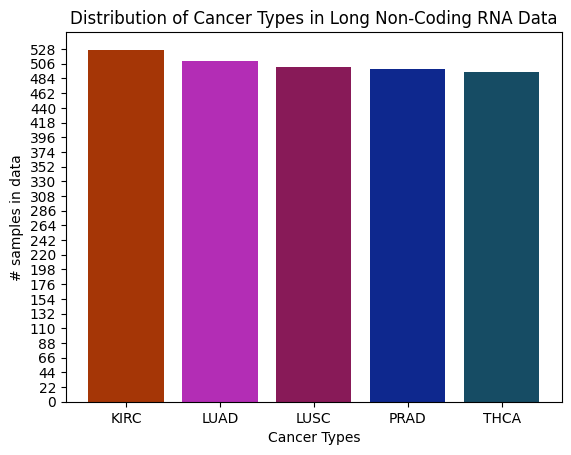

In [2]:

# Counting each cancer type
cancer_type_counts = data['Class'].value_counts()
classes = data['Class'].unique().tolist()
print(cancer_type_counts)
print(f"Total number of data points: {data.shape[0]}.\nTotal number of features: {data.shape[1]-1}",)

# Creating bar chart 
plt.bar(classes,cancer_type_counts,color=['#a53606', '#b32db5', '#881a58', '#0e288e', '#164c64'])
plt.xlabel("Cancer Types")
plt.ylabel("# samples in data")
plt.title("Distribution of Cancer Types in Long Non-Coding RNA Data")
plt.yticks([x for x in range(0,550,22)])
plt.show()


## Task 2

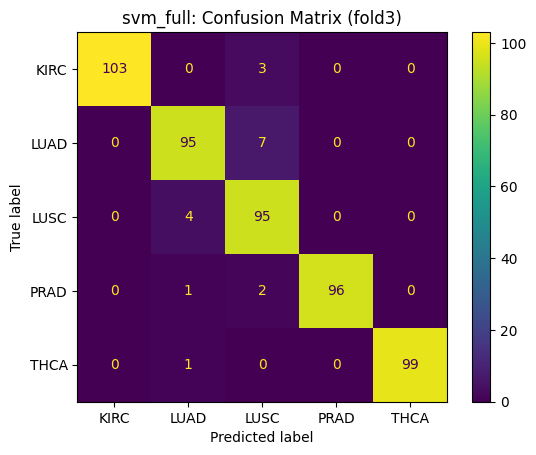

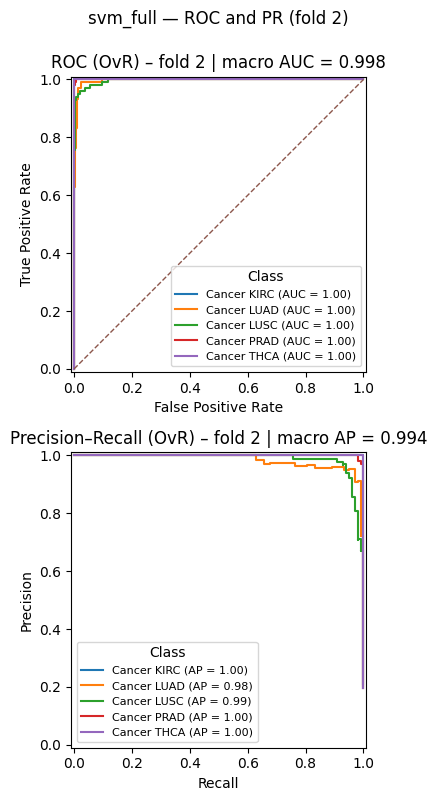

                        mean       std
accuracy            0.956898  0.012143
precision_macro     0.961943  0.008575
recall_macro        0.956652  0.012353
f1_macro            0.957615  0.011613
precision_micro     0.956898  0.012143
recall_micro        0.956898  0.012143
f1_micro            0.956898  0.012143
precision_weighted  0.961871  0.008743
recall_weighted     0.956898  0.012143
f1_weighted         0.957701  0.011603
roc_auc             0.997416  0.001254
avg_precision       0.990603  0.004394
Wall time (all folds): 235.4s


<Figure size 640x480 with 0 Axes>

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score,precision_recall_fscore_support,roc_auc_score,average_precision_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,PrecisionRecallDisplay)
import json
import time

# Defining output locations
OUT_METRICS = ROOT/"reports"/"metrics"
OUT_FIGS = ROOT/"reports"/"figures"
OUT_METRICS.mkdir(parents=True,exist_ok=True)
OUT_FIGS.mkdir(parents=True,exist_ok=True)

# Setting data into feature set and label set for classification
feature_set = data.to_numpy()[:,1:data.shape[1] - 1] # strips ID column and labels from data table leaving only feature set
output_labels = data.to_numpy()[:,-1] # isolates labels indexed by sample 

n_splits = 5
seed = 42
plots_fold = 2
method = "svm_full"

# Using the SKLEARN helper class to partition data for training and testing
kfold_cross = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=seed) #given kernel, probablity, and random_state for the sake of reproducibility

# KFold Cross Validation Loop
folds = {}
results = []
k = 1
t0_all  = time.perf_counter()
for train_idx, test_idx in kfold_cross.split(feature_set,output_labels):
    # Generate the partitions for kfold cross validation
    feature_training_set, feature_validation_set = feature_set[train_idx], feature_set[test_idx]
    training_labels, validation_labels = output_labels[train_idx], output_labels[test_idx] 

    # Store the partitions for Tasks 3 & 4
    folds[f"train_{k}"] = train_idx
    folds[f"valid_{k}"] = test_idx

    # Initializing Support Vector Machine (SVM) for classification
    model = make_pipeline(
        StandardScaler(), #This was used to ensure large variance in the magnitude of values between features didn't skew the model. This particular scalar was chosen to keep things simple though. I don't yet understand why I might change things here.
        SVC(kernel="rbf",probability=True,random_state=seed) #given kernel, probablity, and random_state for the sake of reproducibility
    )
    # Training the model on fold K
    model.fit(feature_training_set,training_labels)

    # Getting predicted classification from model
    predicted_labels = model.predict(feature_validation_set)
    predicted_probability = model.predict_proba(feature_validation_set)

    # Metrics
    ## Accuracy
    accuracy = accuracy_score(validation_labels,predicted_labels) #SKLEARN metric function that computes accuracy
    ## Macro prec/recall/f1
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="macro",zero_division=0) 
    ## Micro prec/recall/f1
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="micro",zero_division=0) 
    ## Weighted prec/recall/f1
    precision_weight, recall_weight, f1_weight, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="weighted",zero_division=0) 

    # AUC curves
    roc_auc = roc_auc_score(validation_labels,predicted_probability,average="macro",multi_class='ovr')
    bins = label_binarize(validation_labels,classes=classes)
    ap_auc = average_precision_score(bins,predicted_probability,average="macro")

    results.append({"fold":k,"accuracy":accuracy,"precision_macro":precision_macro,"recall_macro":recall_macro,"f1_macro":f1_macro,
                    "precision_micro":precision_micro,"recall_micro":recall_micro,"f1_micro":f1_micro,
                    "precision_weighted":precision_weight,"recall_weighted":recall_weight,"f1_weighted":f1_weight,
                    "roc_auc":roc_auc,"avg_precision":ap_auc
    })

    # Plotting
    if k == plots_fold:

        ## Plotting Confusion Matrix
        my_confusion_matrix = confusion_matrix(validation_labels,predicted_labels,labels=classes)
        ConfusionMatrixDisplay(my_confusion_matrix,display_labels=classes).plot(values_format="d")
        plt.title(f"{method}: Confusion Matrix (fold{k+1})")
        plt.show()
        plt.savefig(OUT_FIGS/f"{method}_cm_fold{k}.png")
        plt.close()

        fig, axes = plt.subplots(2,1,figsize=(6.0,8.0))
        ax_roc,ax_pr = axes
        
        ## Plotting ROC Curve
        for i, cls in enumerate(classes):
            RocCurveDisplay.from_predictions(bins[:,i],predicted_probability[:,i],name=f"Cancer {cls}",ax=ax_roc)
        
        ax_roc.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
        ax_roc.set_title(f"ROC (OvR) – fold {k} | macro AUC = {roc_auc:.3f}")
        ax_roc.set_xlabel("False Positive Rate")
        ax_roc.set_ylabel("True Positive Rate")
        ax_roc.legend(title="Class", loc="lower right", fontsize=8)

        ## Plotting PR
        for i, cls in enumerate(classes):
            PrecisionRecallDisplay.from_predictions(bins[:,i],predicted_probability[:,i],name=f"Cancer {cls}",ax=ax_pr)

        ax_pr.set_title(f"Precision–Recall (OvR) – fold {k} | macro AP = {ap_auc:.3f}")
        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.legend(title="Class", loc="lower left", fontsize=8)   
        
        fig.suptitle(f"{method} — ROC and PR (fold {k})", y=0.995)
        fig.tight_layout()
        plt.show()
        plt.savefig(OUT_FIGS / f"{method}_roc_pr_fold{k}.png", bbox_inches="tight", pad_inches=0.02)
        plt.close(fig)

    k += 1

# Writing stored info to file
kfold_partition_data_path = SPLIT_DIR/f"folds_{n_splits}_seed_{seed}.npz"
np.savez(kfold_partition_data_path,**folds)

meta = {
    "n_splits": n_splits,
    "shuffle": True,
    "random_state": seed,
    "n_samples": int(len(output_labels))
}
(SPLIT_DIR/"meta.json").write_text(json.dumps(meta,indent=2))

t1_all = time.perf_counter()

result_df = pd.DataFrame(results).sort_values("fold")
result_df.to_csv(OUT_METRICS/f"{method}_per_fold.csv", index=False)

summary = result_df.drop(columns=["fold"]).agg(["mean","std"]).T
summary.to_csv(OUT_METRICS / f"{method}_cv_summary.csv")
print(summary)
print(f"Wall time (all folds): {(t1_all - t0_all):.1f}s")


## Task 3

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

class AutoEncoder(nn.Module):
    """This will make a symmetric autoencoder that has following widths
        ~12k > 1024 > 256 > 50 > 256 > 1024 > ~12k
       |_input_|___encoder___|____decoder____|_output_|
    """
    def __init__(self, feature_set_dimension, latent_dimension=50, hidden_layer_widths=(1024,256)):
        super().__init__()

        # Building the encoder 
        '''
        Each layer is linear but hidden layers have ReLU activation function
        '''
        encoder_layers = [] # we create a list to layer widths and loop through the input informations
        current_layer_width = feature_set_dimension
        for next_layer_width in hidden_layer_widths:
            encoder_layers += [nn.Linear(current_layer_width,next_layer_width),nn.ReLU()]
            current_layer_width = next_layer_width
        self.encoder = nn.Sequential(*encoder_layers,nn.Linear(current_layer_width,latent_dimension)) # sequential stacks the encoder layers with the last layer being the bottleneck layer

        # Building the decoder
        ''' A symmetric decoder is constructed'''
        decoder_layers = []
        current_layer_width = latent_dimension
        for next_layer_width in reversed(hidden_layer_widths):
            decoder_layers += [nn.Linear(current_layer_width,next_layer_width),nn.ReLU()]
            current_layer_width = next_layer_width
        decoder_layers += [nn.Linear(current_layer_width,feature_set_dimension)]
        self.decoder = nn.Sequential(*decoder_layers)

    # Defining the forward pass
    def forward(self,x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat,z
    
@torch.no_grad()
def encode_with_ae(model,X,device):
    model.eval()
    Z = []
    bs = 1024
    for i in range(0,X.shape[0],bs):
        xb = torch.from_numpy(X[i:i+bs].astype(np.float32)).to(device=device)
        zb = model.encoder(xb)
        Z.append(zb.cpu().numpy())
    return np.concatenate(Z,axis=0)

def train_autoencoder(X_train_scaled, *,latent_dimension=50, hidden_layer_widths=(1024,256),valid_frac=0.1, batch_size=256,max_epochs=40,patience=5,lr=1e-3,weight_decay=1e-5,seed=42,device=None):
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # making random but deterministic train/validate split
    X = torch.from_numpy(X_train_scaled.astype(np.float32))
    ds = TensorDataset(X)
    n_val = int(len(ds) * valid_frac)
    n_tr = len(ds) - n_val
    ds_tr, ds_val = random_split(ds,[n_tr,n_val], generator=torch.Generator().manual_seed(seed))

    # Loading data
    dl_tr = DataLoader(ds_tr,batch_size=batch_size, shuffle=True,drop_last=False)
    dl_val = DataLoader(ds_val,batch_size=batch_size, shuffle=False,drop_last=False)

    model = AutoEncoder(feature_set_dimension=X.shape[1],latent_dimension=latent_dimension,hidden_layer_widths=hidden_layer_widths).to(device=device)
    opt = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay) # we use an adam optimizer. I learned about this in my Optimization course last semester but here I follow a tutorial
    crit = nn.MSELoss()
    #assert isinstance(crit,nn.MSELoss)

    best = {"loss": float("inf"), "state":None}
    epochs_no_improvement = 0

    # Training loop
    for epoch in range(max_epochs):
        model.train()
        tr_loss = 0.0
        for(xb,) in dl_tr:
            xb = xb.to(device)
            opt.zero_grad(True)
            xhat, _ = model(xb)
            loss = crit(xhat,xb)
            assert isinstance(loss,torch.Tensor)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= n_tr

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (xb,) in dl_val:
                xb = xb.to(device)
                xhat,_ = model(xb)
                val_loss += crit(xhat,xb).item() * xb.size(0)
        val_loss /= max(n_val,1)

        if val_loss < best["loss"] - 1e-6:
            best["loss"] = val_loss
            best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improvement = 0
        else:
            epochs_no_improvement += 1
            if epochs_no_improvement >= patience:
                break
    
    if best["state"] is not None:
        model.load_state_dict(best["state"])
    return model.to(device), best["loss"]


With the Autoencoder constructed, no we apply the autoencoder for feature extraction using the original dataset

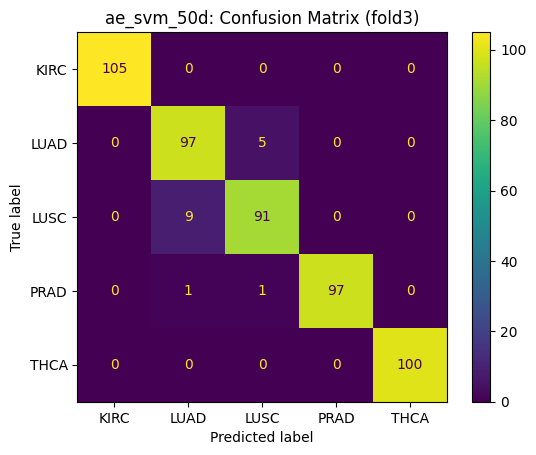

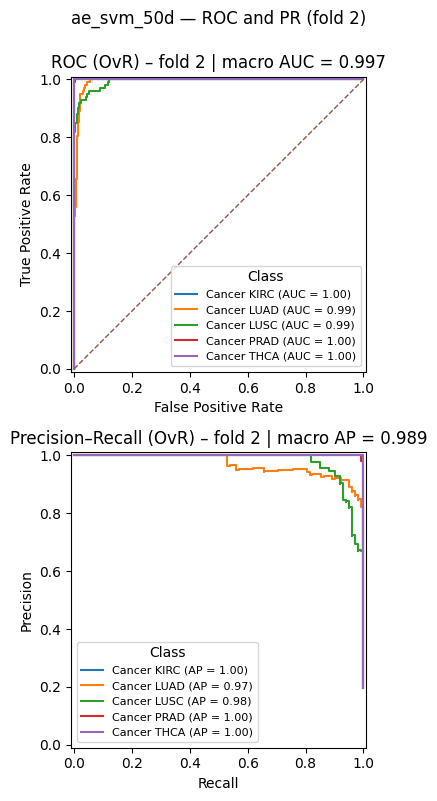

                        mean       std
accuracy            0.973507  0.005157
precision_macro     0.974049  0.005182
recall_macro        0.973356  0.005147
f1_macro            0.973475  0.005116
precision_micro     0.973507  0.005157
recall_micro        0.973507  0.005157
f1_micro            0.973507  0.005157
precision_weighted  0.974035  0.005174
recall_weighted     0.973507  0.005157
f1_weighted         0.973544  0.005121
roc_auc             0.997797  0.000931
avg_precision       0.991209  0.003844
ae_val_recon_loss   0.614177  0.034274
Wall time (all folds): 149.3s


<Figure size 640x480 with 0 Axes>

In [ ]:

method      = "ae_svm_50d"
n_splits    = 5
seed        = 42
plots_fold  = 2                      # show figures for this fold index (0..4), keep consistent
device      = "cuda" if torch.cuda.is_available() else "cpu"

# Loading splits from previous 5-CV to compare
split_path = SPLIT_DIR / f"folds_{n_splits}_seed_{seed}.npz"
splits = np.load(split_path)

has_zero_based = f"train_0" in splits.files or f"val_0" in splits.files or f"valid_0" in splits.files
idx_base = 0 if has_zero_based else 1
val_prefix = "val_" if any(k.startswith("val_") for k in splits.files) else "valid_"

fold_pairs = [(splits[f"train_{i+idx_base}"], splits[f"{val_prefix}{i+idx_base}"]) for i in range(n_splits)]

results = []
t0_all  = time.perf_counter()
for k, (train_idx, test_idx) in enumerate(fold_pairs):
    # Generate the partitions for kfold cross validation
    feature_training_set, feature_validation_set = feature_set[train_idx], feature_set[test_idx]
    training_labels, validation_labels = output_labels[train_idx], output_labels[test_idx] 

    # Scaling Data for Autoencoder
    scaler = StandardScaler().fit(feature_training_set)
    scaled_training_set   = scaler.transform(feature_training_set).astype(np.float32)
    scaled_validation_set  = scaler.transform(feature_validation_set).astype(np.float32)

    t0 = time.perf_counter()
    ae_model, best_rec_val = train_autoencoder(scaled_training_set)
    # Feature Extraction
    extracted_features_training = encode_with_ae(ae_model,scaled_training_set,device=device)
    extracted_features_validation = encode_with_ae(ae_model,scaled_validation_set,device=device)

    # SVM classifcation on extracted features
    svm = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", probability=True, cache_size=1000, random_state=seed)
    )

    svm.fit(extracted_features_training,training_labels)
    predicted_labels = svm.predict(extracted_features_validation)
    predicted_score = svm.decision_function(extracted_features_validation)
    predicted_probability = svm.predict_proba(extracted_features_validation)

    # Metrics
    ## Accuracy
    accuracy = accuracy_score(validation_labels,predicted_labels) #SKLEARN metric function that computes accuracy
    ## Macro prec/recall/f1
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="macro",zero_division=0) 
    ## Micro prec/recall/f1
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="micro",zero_division=0) 
    ## Weighted prec/recall/f1
    precision_weight, recall_weight, f1_weight, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="weighted",zero_division=0) 

    # AUC curves
    roc_auc = roc_auc_score(validation_labels,predicted_probability,average="macro",multi_class='ovr')
    bins = label_binarize(validation_labels,classes=classes)
    ap_auc = average_precision_score(bins,predicted_probability,average="macro")

    results.append({"fold":k,"accuracy":accuracy,"precision_macro":precision_macro,"recall_macro":recall_macro,"f1_macro":f1_macro,
                    "precision_micro":precision_micro,"recall_micro":recall_micro,"f1_micro":f1_micro,
                    "precision_weighted":precision_weight,"recall_weighted":recall_weight,"f1_weighted":f1_weight,
                    "roc_auc":roc_auc,"avg_precision":ap_auc,"ae_val_recon_loss": best_rec_val
    })

    # Plotting
    if k == plots_fold:

        ## Plotting Confusion Matrix
        my_confusion_matrix = confusion_matrix(validation_labels,predicted_labels,labels=classes)
        ConfusionMatrixDisplay(my_confusion_matrix,display_labels=classes).plot(values_format="d")
        plt.title(f"{method}: Confusion Matrix (fold{k+1})")
        plt.show()
        plt.savefig(OUT_FIGS/f"{method}_cm_fold{k}.png")
        plt.close()

        fig, axes = plt.subplots(2,1,figsize=(6.0,8.0))
        ax_roc,ax_pr = axes
        
        ## Plotting ROC Curve
        for i, cls in enumerate(classes):
            RocCurveDisplay.from_predictions(bins[:,i],predicted_probability[:,i],name=f"Cancer {cls}",ax=ax_roc)
        
        ax_roc.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
        ax_roc.set_title(f"ROC (OvR) – fold {k} | macro AUC = {roc_auc:.3f}")
        ax_roc.set_xlabel("False Positive Rate")
        ax_roc.set_ylabel("True Positive Rate")
        ax_roc.legend(title="Class", loc="lower right", fontsize=8)

        ## Plotting PR
        for i, cls in enumerate(classes):
            PrecisionRecallDisplay.from_predictions(bins[:,i],predicted_probability[:,i],name=f"Cancer {cls}",ax=ax_pr)

        ax_pr.set_title(f"Precision–Recall (OvR) – fold {k} | macro AP = {ap_auc:.3f}")
        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.legend(title="Class", loc="lower left", fontsize=8)   
        
        fig.suptitle(f"{method} — ROC and PR (fold {k})", y=0.995)
        fig.tight_layout()
        plt.show()
        plt.savefig(OUT_FIGS / f"{method}_roc_pr_fold{k}.png", bbox_inches="tight", pad_inches=0.02)
        plt.close(fig)

    k += 1

# Writing stored info to file
kfold_partition_data_path = SPLIT_DIR/f"folds_{n_splits}_seed_{seed}.npz"
np.savez(kfold_partition_data_path,**folds)

t1_all = time.perf_counter()

result_df = pd.DataFrame(results).sort_values("fold")
result_df.to_csv(OUT_METRICS/f"{method}_per_fold.csv", index=False)

summary = result_df.drop(columns=["fold"]).agg(["mean","std"]).T
summary.to_csv(OUT_METRICS / f"{method}_cv_summary.csv")
print(summary)
print(f"Wall time (all folds): {(t1_all - t0_all):.1f}s")


We see similar performance when classifying with the extracted feature set compared to the the entire feature set. Although many of the scores are slightly lower, they ore $O(10^{-2})$ so they are unlikely to be significant dips in performance. We gained a lot from this approach,however; runtime went from 235s to  150s roughly 36% decrease in wall time for a minimal drop in performance.

Conclusions: Feature Extraction seems useful for this kind of problem especially when capped by compute resources.

# Task 4